In [12]:
import os, sys
from matplotlib import pyplot as plt
import numpy as np
import rasterio as rio
from scipy.misc import bytescale
from rasterio.mask import mask
from glob import glob

# add the unet helpers
sys.path.append('../../')
# from test_unet_helpers import *
# from unet_models import unet11_MS
from utils import variable

import matplotlib
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

from torchsat.models.segmentation.unet import UNetResNet
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc, f1_score, precision_score, recall_score
import torch
from collections import OrderedDict



In [13]:
# lulc_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/dg_products/tiles_d10000_256x256/val/lulc*.tif'))
# bue_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/dg_products/tiles_d10000_256x256/val/bue*.tif'))
# unet_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/dg_products/tiles_d10000_256x256/val/unet*.tif'))
# dg_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val/dg*.tif'))
# gt_files = sorted(glob('../../RD/debug_IS_segmentation/kmeans3_split/tiles_d10000_256x256/val/gt*.tif'))

lulc_files = sorted(glob('../../../tiles/dg_products/tiles_d10000_256x256/val/lulc*.tif'))
bue_files = sorted(glob('../../../tiles/dg_products/tiles_d10000_256x256/val/bue*.tif'))
unet_files = sorted(glob('../../../tiles/dg_products/tiles_d10000_256x256/val/unet*.tif'))
dg_files = sorted(glob('../../../tiles/kmeans3_split/tiles_d10000_256x256/val/dg*.tif'))
gt_files = sorted(glob('../../../tiles/kmeans3_split/tiles_d10000_256x256/val/gt*.tif'))

lulc_files = sorted(glob('../tiles/dg_products/tiles_d10000_256x256/val/lulc*.tif'))
bue_files = sorted(glob('../tiles/dg_products/tiles_d10000_256x256/val/bue*.tif'))
unet_files = sorted(glob('../tiles/dg_products/tiles_d10000_256x256/val/unet*.tif'))
dg_files = sorted(glob('../tiles/kmeans3_split/tiles_d10000_256x256/val/dg*.tif'))
gt_files = sorted(glob('../tiles/kmeans3_split/tiles_d10000_256x256/val/gt*.tif'))

In [14]:
lulc_files[:5], bue_files[:5]
# !ls ../tiles/

(['../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00500.tif',
  '../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00501.tif',
  '../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00502.tif',
  '../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00503.tif',
  '../tiles/dg_products/tiles_d10000_256x256/val/lulc_is_00504.tif'],
 ['../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00500.tif',
  '../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00501.tif',
  '../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00502.tif',
  '../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00503.tif',
  '../tiles/dg_products/tiles_d10000_256x256/val/bue_is_00504.tif'])

## iterate through the ground truth raster and process a window which has more than 80% impervious cover

## iterate over the UNet results

In [15]:
# RGB-NIR
model_path = './files_MS_aug_bgrn1/jstars_bgrn1_ms_aug_ep500_step8000_b32.pt'

torch.cuda.empty_cache()

#model = unet11(pretrained=False) # B-G-R
model = UNetResNet(encoder_depth=152, num_classes=1, in_channels=4, num_filters=32, dropout_2d=0.2,
                 pretrained=False, is_deconv=True)

# load on CPU
if os.path.exists(model_path):
    state_dict = torch.load(str(model_path), map_location='cpu')
    epoch = state_dict['epoch']
    step = state_dict['step']
    new_state_dict = OrderedDict()
    for k, v in state_dict['model'].items():
        name = k[7:] # remove 'module.' of dataparallel
        new_state_dict[name]=v

    model.load_state_dict(new_state_dict)
    #print('Restored model, epoch {}, step {:,}'.format(epoch, step))

model.eval();

In [16]:
# define a function to load and run model
def run_model(chip, mod):   
    

    img_arr = chip[[1,2,4,6], :, :] #B-G-R-N1
    img_arr = torch.from_numpy(img_arr)

    input_img = torch.unsqueeze(variable(img_arr, volatile=True), dim=0).cpu()
    del img_arr

    # model inference
    big_mask = model(input_img)

    return big_mask.cpu().detach().numpy().squeeze()

In [17]:

## iterate over the UNET rasters
labels=('UNet 4 band')
unet_label = labels
winsize=100


dg_lulc_auc = []
dg_lulc_fpr = []
dg_lulc_tpr = []
dg_lulc_ap, dg_lulc_f1 = [],[]

dg_bue_auc = []
dg_bue_fpr = []
dg_bue_tpr = []
dg_bue_ap, dg_bue_f1 = [],[]

unet_auc = []
unet_fpr = []
unet_tpr = []
unet_ap, unet_f1 = [],[]

r = []
c = []
for i in range(len(unet_files)):

    # get the gt window
    with rio.open(gt_files[i]) as src:
        target = src.read()
        
    area_thresh = target[target>0].size / target.size

    # check the 80%
    

    try:

        # for LULC
        with rio.open(lulc_files[i]) as src:
            lulc = src.read()
            lulc = np.sum(lulc, axis=0)
            pred = np.zeros(lulc.shape)
            pred[lulc == 384] = 1

        target=target.astype('float32')
        roc_score = roc_auc_score(target.flatten(), pred.flatten())
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
        roc_auc = auc(false_positive_rate, true_positive_rate)
        ap = precision_score(target.flatten(), pred.flatten(), average='binary')
        f1 = f1_score(target.flatten(), pred.flatten(), average='binary')
        dg_lulc_auc.append(roc_auc)
        dg_lulc_fpr.append(false_positive_rate)
        dg_lulc_tpr.append(true_positive_rate)
        dg_lulc_ap.append(ap)
        dg_lulc_f1.append(f1)

        # for BUE
        with rio.open(bue_files[i]) as src:
            pred = src.read()/255

        target=target.astype('float32')
        roc_score = roc_auc_score(target.flatten(), pred.flatten())
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
        roc_auc = auc(false_positive_rate, true_positive_rate)
        ap = precision_score(target.flatten(), pred.flatten(), average='binary')
        f1 = f1_score(target.flatten(), pred.flatten(), average='binary')
        dg_bue_auc.append(roc_auc)
        dg_bue_fpr.append(false_positive_rate)
        dg_bue_tpr.append(true_positive_rate)
        dg_bue_ap.append(ap)
        dg_bue_f1.append(f1)

        # for UNet... need to pass to the model and get the output
        #with rio.open(unet_files[i]) as src:
        #    pred = src.read()
        with rio.open(dg_files[i]) as src:
            dg_arr = src.read()

        pred = run_model(dg_arr, model)
        roc_score = roc_auc_score(target.flatten(), pred.flatten())
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.flatten(), pred.flatten())
        roc_auc = auc(false_positive_rate, true_positive_rate)
        ap = precision_score(target.flatten(), pred.flatten()>0, average='binary')
        f1 = f1_score(target.flatten(), pred.flatten()>0, average='binary')
        unet_auc.append(roc_auc)
        unet_fpr.append(false_positive_rate)
        unet_tpr.append(true_positive_rate)
        unet_ap.append(ap)
        unet_f1.append(f1)


    except Exception as e:
        # we likely have a dimension mismatch
        print(e)
        continue
        
print('finished comparing DG products')

/home/ubuntu/segmentation/IS_UNet_Resnet152/utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))


finished comparing DG products


/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


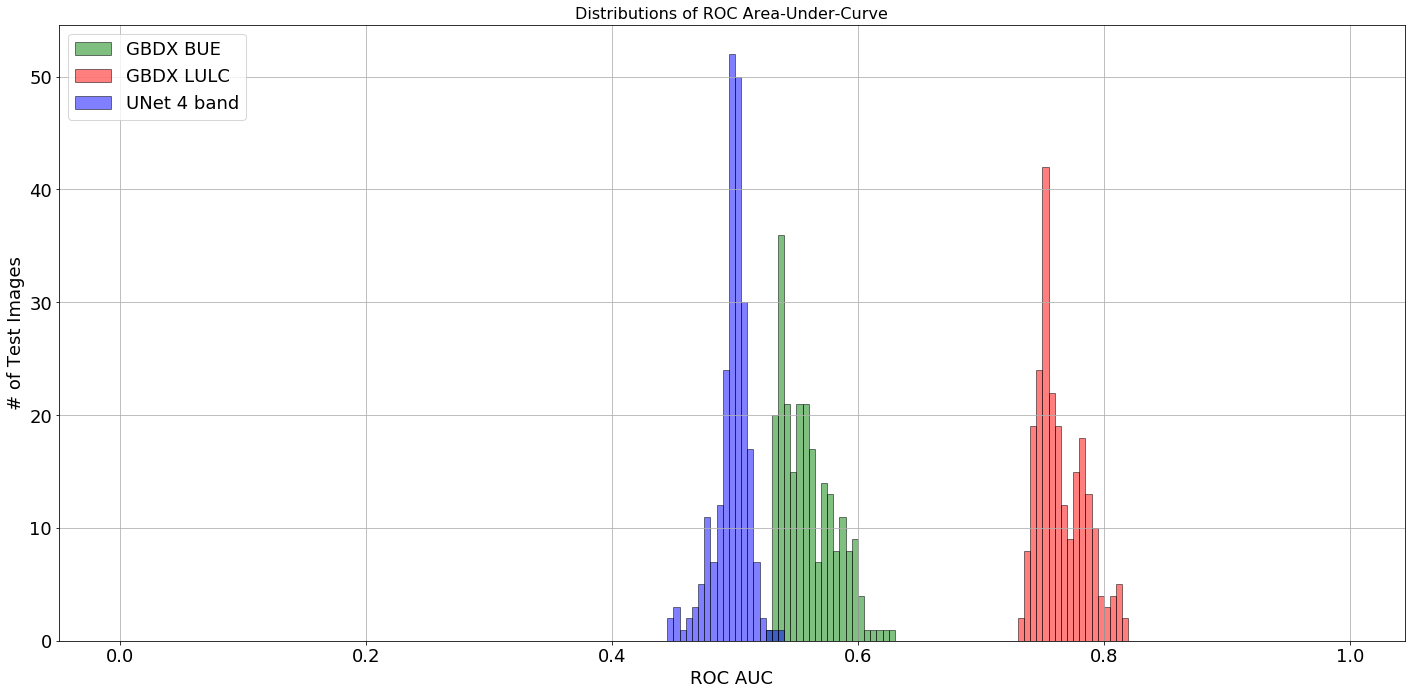

In [19]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

matplotlib.rc('font', **font)

# show the distribution of ROC AUC (area under curve)
plt.figure(figsize=(20,10))
res = 0.005
plt.hist(dg_bue_auc, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
plt.hist(dg_lulc_auc, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
plt.hist(unet_auc, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
plt.legend(loc='upper left')
plt.title('Distributions of ROC Area-Under-Curve', fontsize=16)
plt.ylabel('# of Test Images',)
plt.xlabel('ROC AUC')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figs/test_set_compare_auc.png')
plt.show()

# pick a random sample for TPR vs FPR
#     plt.figure(figsize=(10,5))
#     plt.plot(dg_bue_fpr[10], dg_bue_tpr[10], c='g')
#     plt.plot(dg_lulc_fpr[10], dg_lulc_tpr[10], c='r')
#     plt.plot(unet_fpr[10], unet_tpr[10], c='b')
#     plt.show()

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


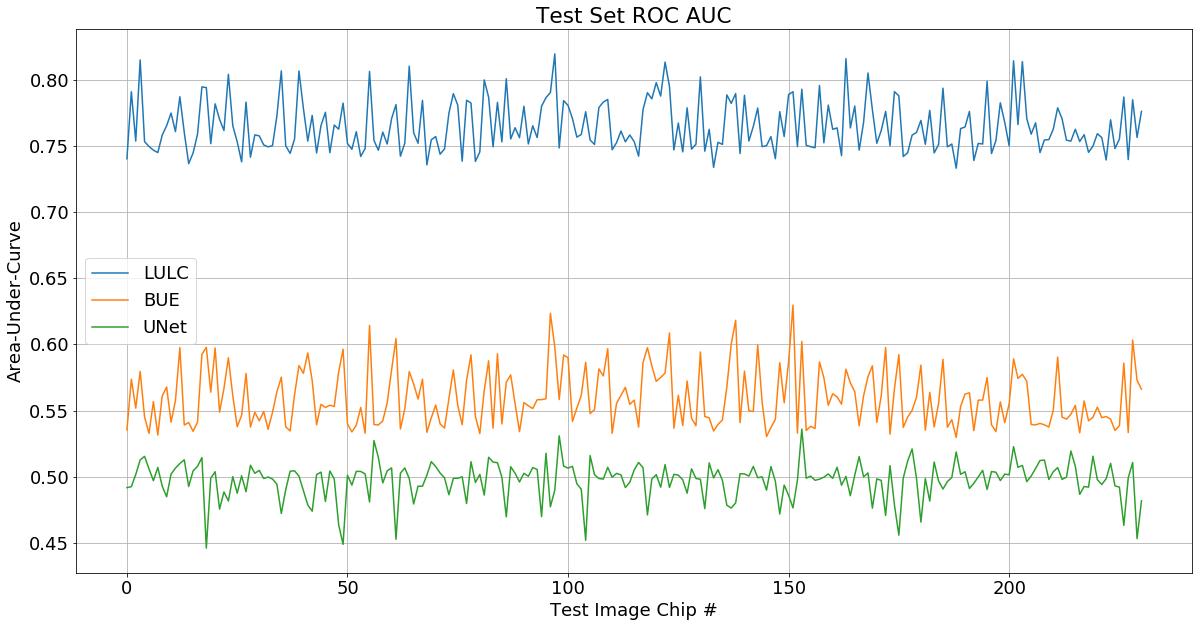

231

In [20]:
plt.figure(figsize=(20,10))
plt.plot(dg_lulc_auc, label='LULC')
plt.plot(dg_bue_auc, label='BUE')
plt.plot(unet_auc, label='UNet')
plt.xlabel('Test Image Chip #')
plt.ylabel('Area-Under-Curve')
plt.title('Test Set ROC AUC')
plt.legend()
plt.grid(True)
plt.show()

len(unet_auc)

Same for F1 score

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


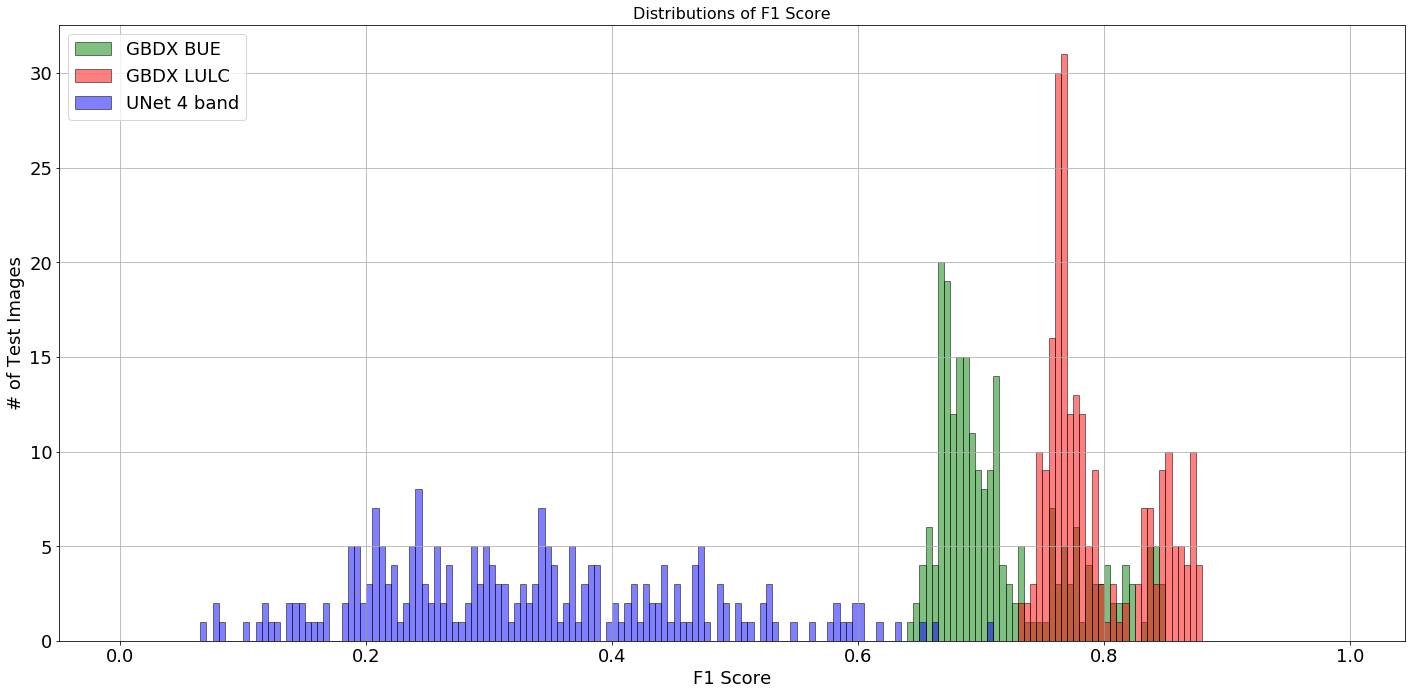

In [21]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

# show the distribution of ROC AUC (area under curve)
plt.figure(figsize=(20,10))
res = 0.005
plt.hist(dg_bue_f1, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
plt.hist(dg_lulc_f1, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
plt.hist(unet_f1, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
plt.legend(loc='upper left')
plt.title('Distributions of F1 Score', fontsize=16)
plt.ylabel('# of Test Images',)
plt.xlabel('F1 Score')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figs/test_set_compare_f1.png')
plt.show()

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


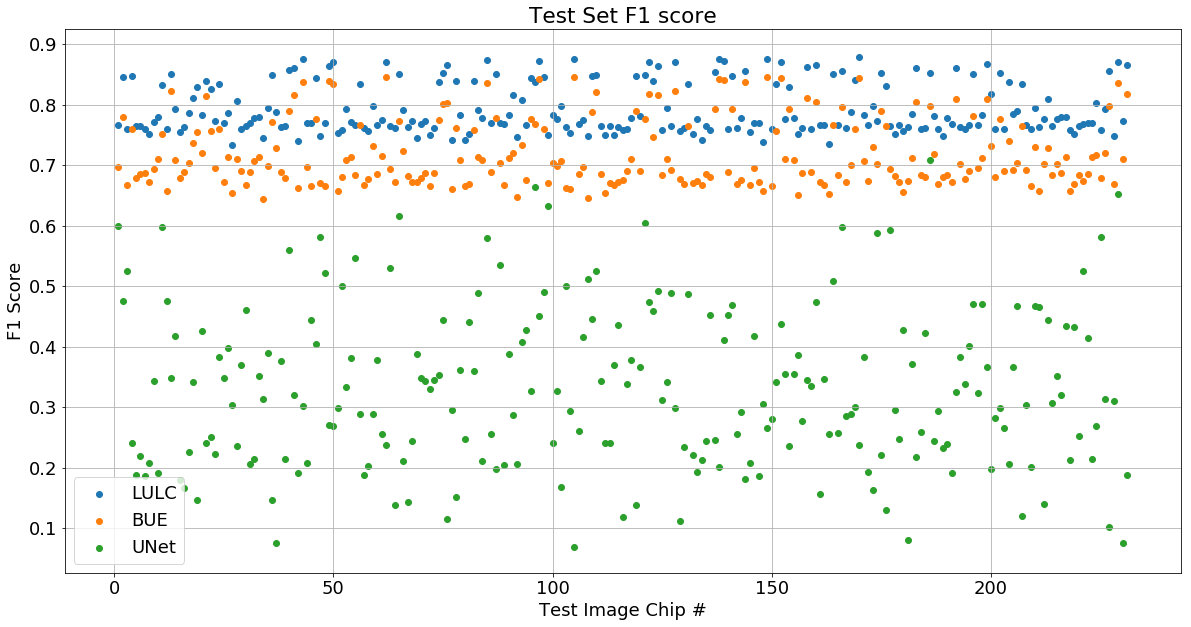

231

In [22]:
plt.figure(figsize=(20,10))
plt.scatter(range(1,len(unet_auc)+1), dg_lulc_f1, label='LULC')
plt.scatter(range(1,len(unet_auc)+1), dg_bue_f1, label='BUE')
plt.scatter(range(1,len(unet_auc)+1), unet_f1, label='UNet')
plt.xlabel('Test Image Chip #')
plt.ylabel('F1 Score')
plt.title('Test Set F1 score')
plt.legend()
plt.grid(True)
plt.show()

len(unet_auc)

Same for AP

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


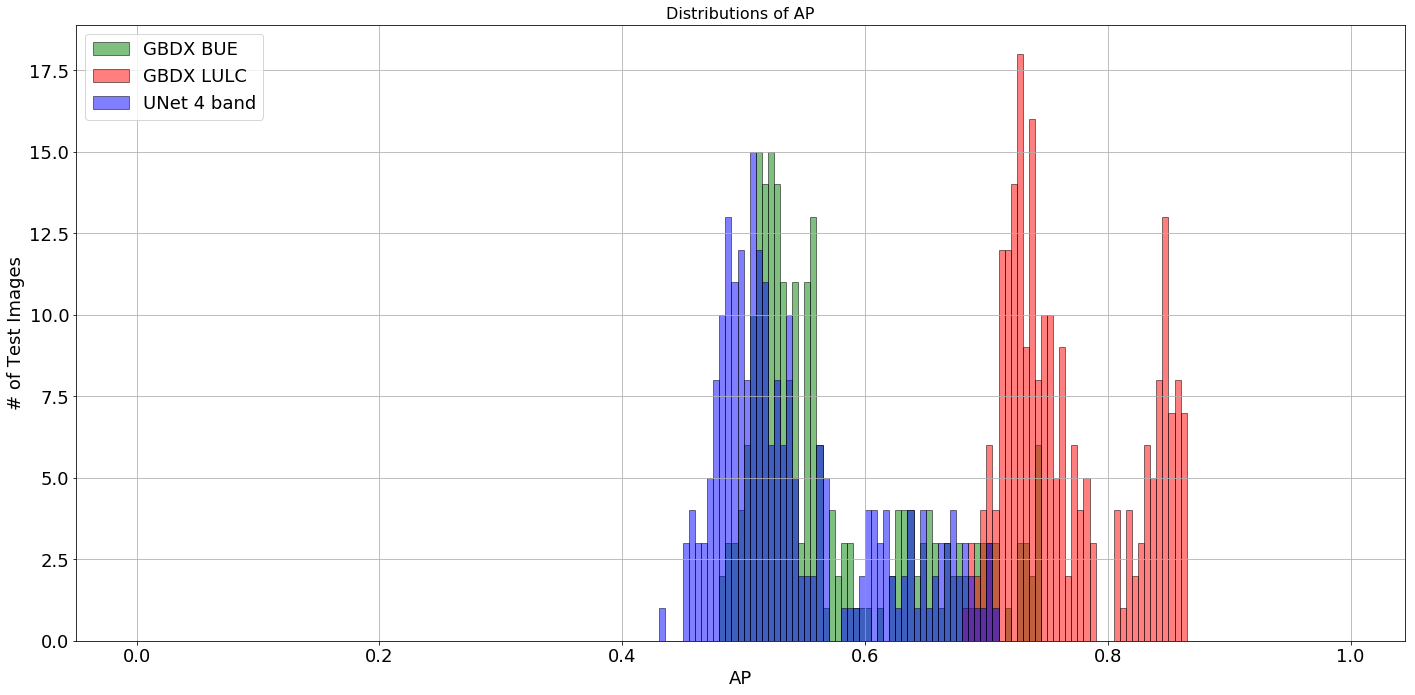

In [23]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

# show the distribution of ROC AUC (area under curve)
plt.figure(figsize=(20,10))
res = 0.005
plt.hist(dg_bue_ap, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
plt.hist(dg_lulc_ap, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
plt.hist(unet_ap, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
plt.legend(loc='upper left')
plt.title('Distributions of AP', fontsize=16)
plt.ylabel('# of Test Images',)
plt.xlabel('AP')
plt.grid(True)
plt.tight_layout()
plt.savefig('./figs/test_set_compare_ap.png')
plt.show()

make a subplot for all 3

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


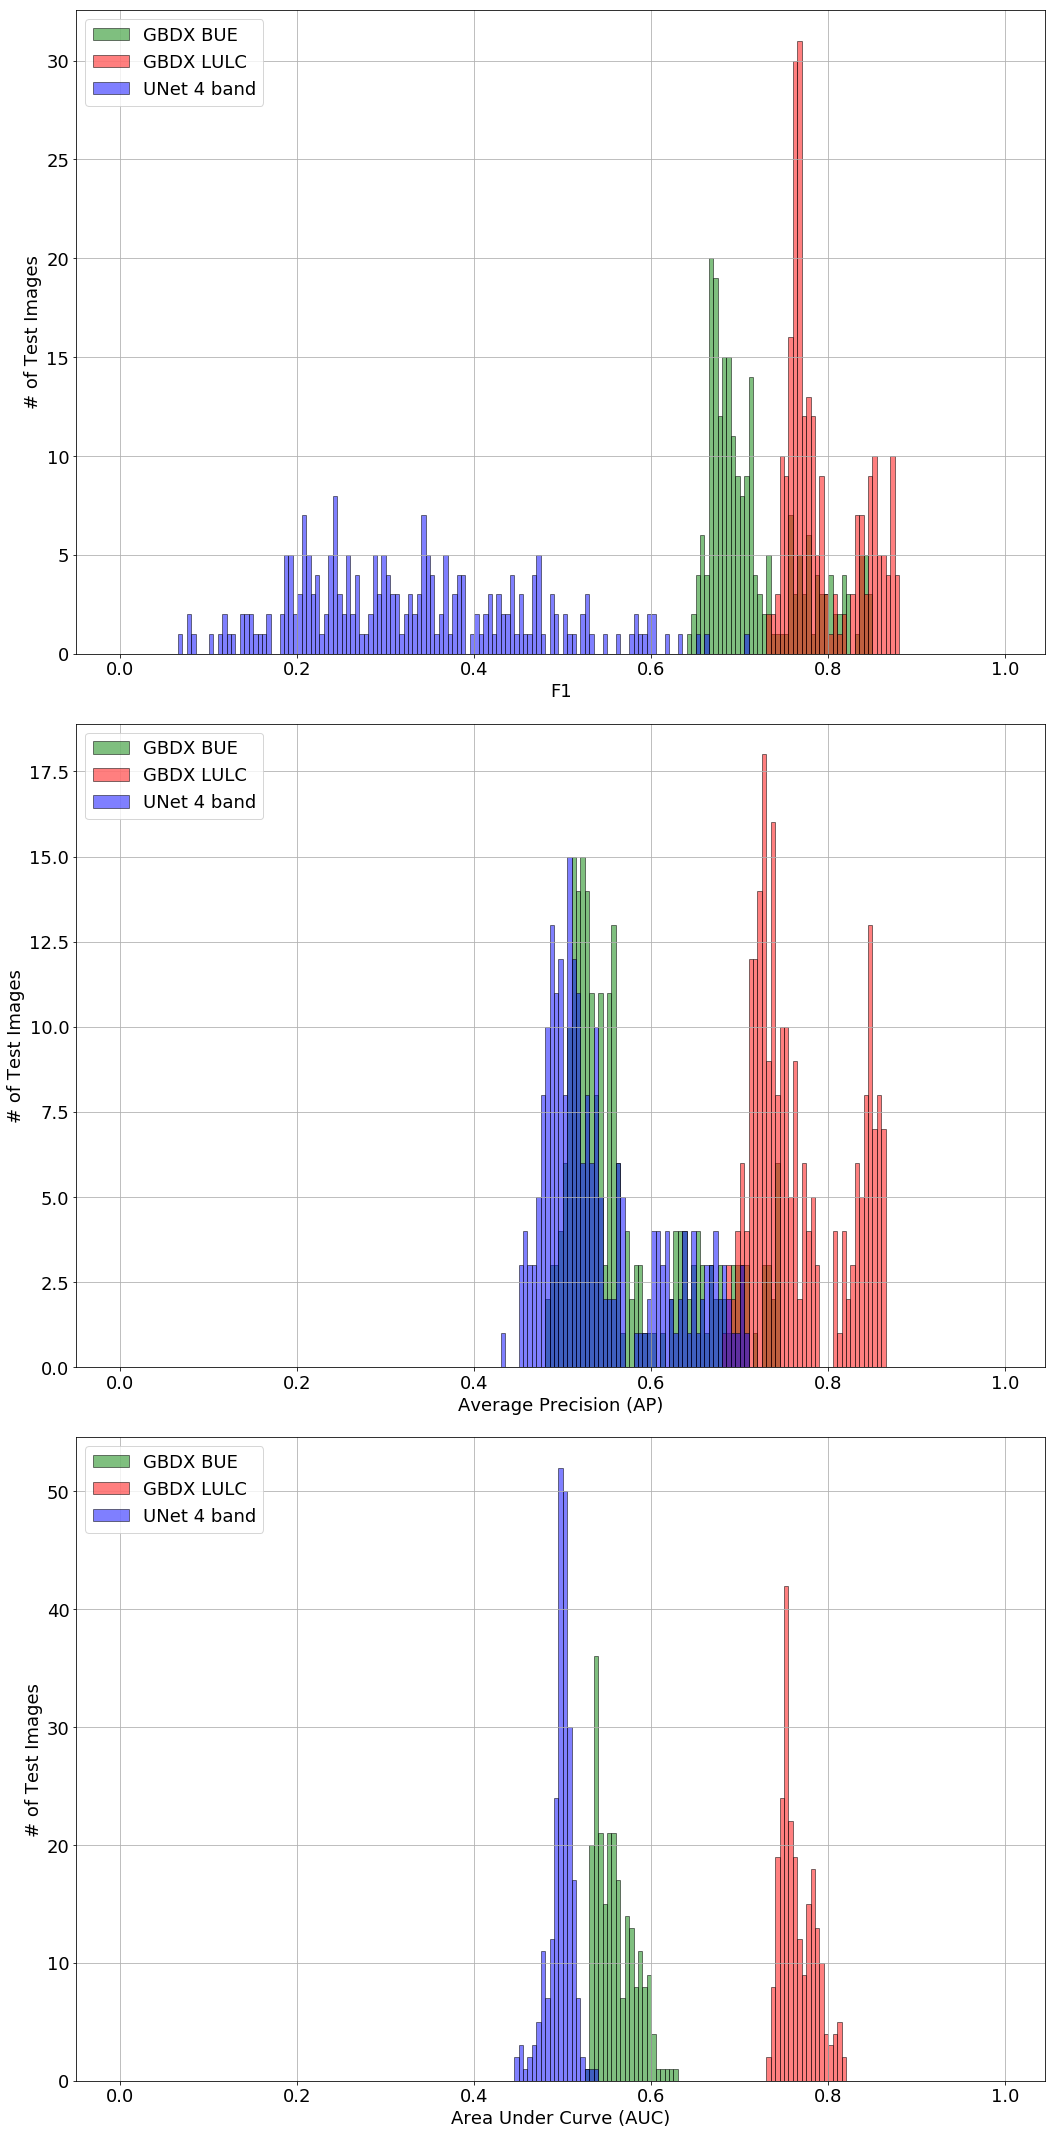

In [26]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 18}

# show the distribution of ROC AUC (area under curve)
fig, ax = plt.subplots(3,1, figsize=(15,30))
res = 0.005

# F1
ax[0].hist(dg_bue_f1, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
ax[0].hist(dg_lulc_f1, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
ax[0].hist(unet_f1, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
ax[0].legend(loc='upper left')
# ax[0].title('Distributions of F1', fontsize=16)
ax[0].set_ylabel('# of Test Images',)
ax[0].set_xlabel('F1')
ax[0].grid(True)

# AP
ax[1].hist(dg_bue_ap, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
ax[1].hist(dg_lulc_ap, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
ax[1].hist(unet_ap, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
ax[1].legend(loc='upper left')
# ax[1].title('Distributions of F1', fontsize=16)
ax[1].set_ylabel('# of Test Images',)
ax[1].set_xlabel('Average Precision (AP)')
ax[1].grid(True)

# AUC
ax[2].hist(dg_bue_auc, bins=np.arange(0., 1., res), color='g', alpha=0.5, edgecolor='k', label='GBDX BUE');
ax[2].hist(dg_lulc_auc, bins=np.arange(0., 1., res), color='r', alpha=0.5, edgecolor='k', label='GBDX LULC');
ax[2].hist(unet_auc, bins=np.arange(0., 1., res), color='b', alpha=0.5, edgecolor='k', label=unet_label)
ax[2].legend(loc='upper left')
# ax[2].title('Distributions of F1', fontsize=16)
ax[2].set_ylabel('# of Test Images',)
ax[2].set_xlabel('Area Under Curve (AUC)')
ax[2].grid(True)


plt.grid(True)
plt.tight_layout()
plt.savefig('./figs/test_set_compare_all_metrics.png')
plt.show()

copy to s3

In [12]:
!aws s3 cp ./figs/test_set_compare_ap.png s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/
!aws s3 cp ./figs/test_set_compare_auc.png s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/
!aws s3 cp ./figs/test_set_compare_f1.png s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/

upload: figs/test_set_compare_ap.png to s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/test_set_compare_ap.png
upload: figs/test_set_compare_auc.png to s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/test_set_compare_auc.png
upload: figs/test_set_compare_f1.png to s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/test_set_compare_f1.png


../../utils.py:16: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  return cuda(Variable(x, volatile=volatile))
/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


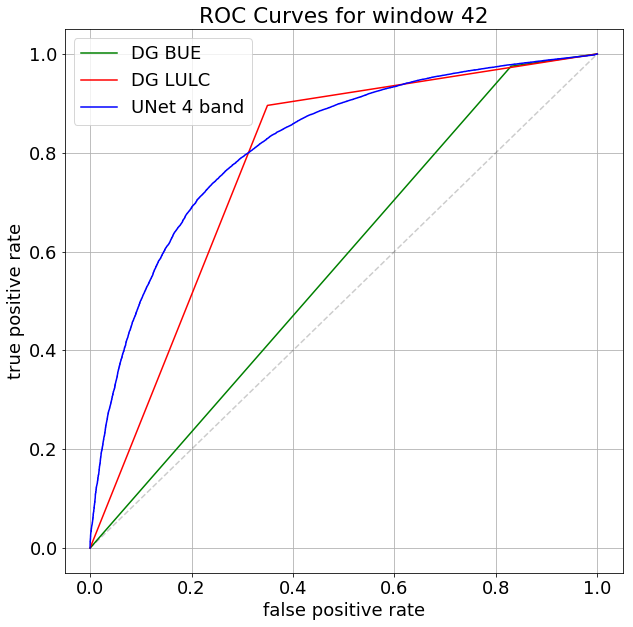

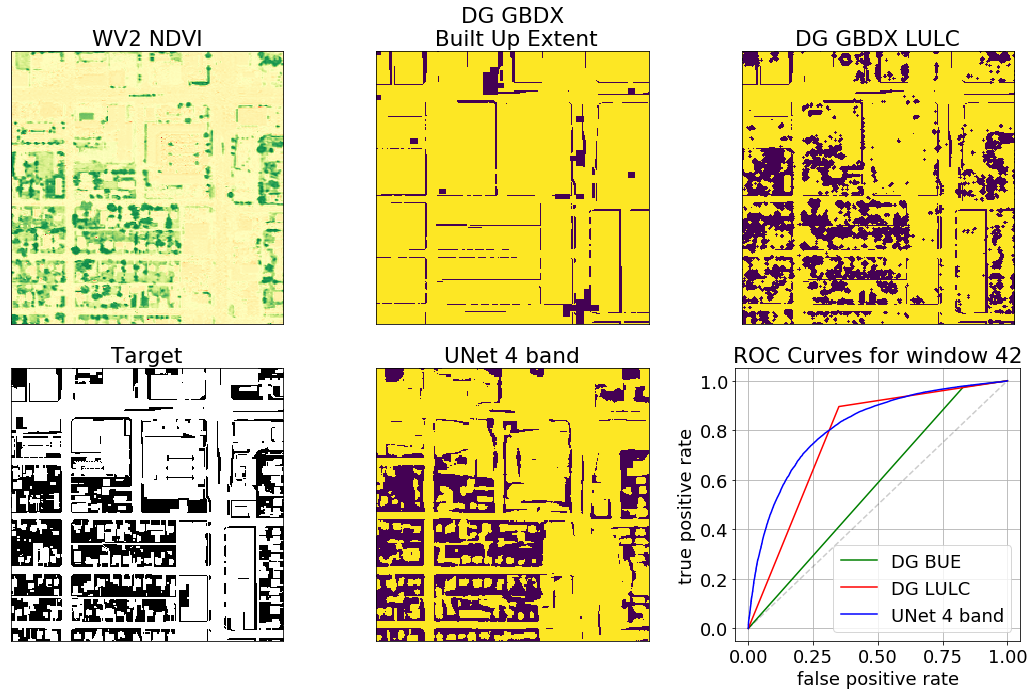

upload: figs/test_example_window42.png to s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/test_example_window42.png


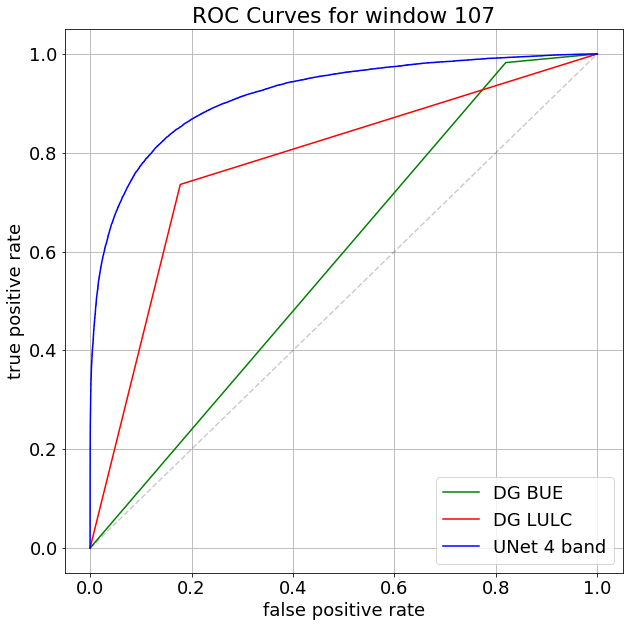

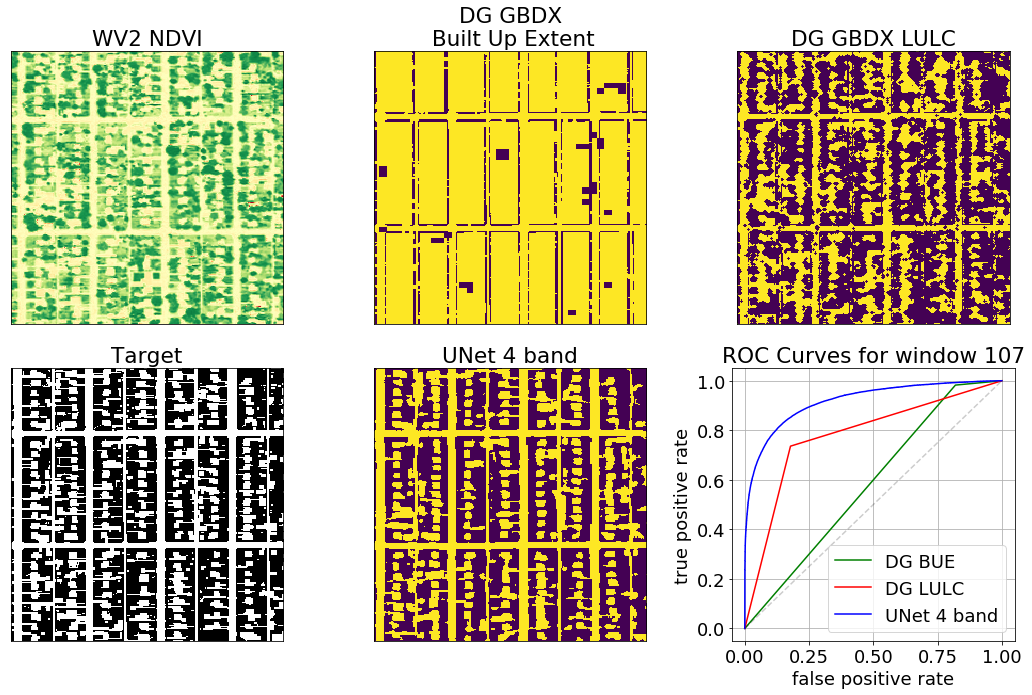

upload: figs/test_example_window107.png to s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/test_example_window107.png


In [13]:
from scipy.misc import bytescale


# pick a random sample for TPR vs FPR
np.random.seed(22)
#for randind in np.random.choice(len(dg_bue_fpr), 42, replace=False):
#for randind in range(len(unet_files)):
for randind in [42, 107]:
    
    # read data
    #lulc
    with rio.open(lulc_files[randind]) as src:
        lulc = src.read()
        lulc = np.sum(lulc, axis=0)
        manmade = np.zeros(lulc.shape)
        manmade[lulc == 384] = 1
    
    #unet
    #with rio.open(unet_files[i]) as src:
    #    arr = src.read(1)
    
    with rio.open(dg_files[randind]) as src:
        dg_arr = src.read()

    arr = run_model(dg_arr, model)
        
    #bue
    with rio.open(bue_files[randind]) as src:
        dg_bue_arr = src.read(1)
    
    #gt
    with rio.open(gt_files[randind]) as src:
        gt_arr = src.read(1)
        
    #dg
    with rio.open(dg_files[randind]) as src:
        src_arr = src.read()
        src_arr = np.rollaxis(src_arr, 0,3)
    
    plt.figure(figsize=(10,10))
    plt.plot(dg_bue_fpr[randind], dg_bue_tpr[randind], 'g', label='DG BUE')
    plt.plot(dg_lulc_fpr[randind], dg_lulc_tpr[randind],'r', label='DG LULC')
    plt.plot(unet_fpr[randind], unet_tpr[randind], 'b', label='UNet 4 band')
    plt.plot([0,1], '--k', alpha=0.2)
    plt.legend()
    plt.grid()
    plt.title('ROC Curves for window {}'.format(randind))
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.show()
    
        
    # make a plot for the image arrays
    #fig, ax = plt.subplots(2, 3, figsize=(15,10), sharex='col', sharey='row')
    fig, ax = plt.subplots(2, 3, figsize=(15,10))
    
    # plot the RGB image (top left)
    ndvi = (src_arr[:,:,6] - src_arr[:,:,4]) / (src_arr[:,:,6] + src_arr[:,:,4])
    #ax[0,0].imshow(bytescale(src_arr[:,:, [4,2,1]]))
    #ax[0,0].set_title('WV2 RGB')
    ax[0,0].imshow(ndvi, cmap='RdYlGn')
    ax[0,0].set_title('WV2 NDVI')
    ax[0,0].set_xticks([])
    ax[0,0].set_yticks([])
    
#     cur_axes = fig.gca()
#     cur_axes.axes.get_xaxis().set_ticklabels([])
#     cur_axes.axes.get_yaxis().set_ticklabels([])
    
    # plot the ground truth image (bottom left)
    ax[1,0].imshow(gt_arr, cmap='gray')
    ax[1,0].set_title('Target')
    ax[1,0].set_xticks([])
    ax[1,0].set_yticks([])
    

    # plot the DG images
    ax[0,1].imshow(dg_bue_arr)
    ax[0,1].set_title('DG GBDX\n Built Up Extent')
    ax[0,1].set_xticks([])
    ax[0,1].set_yticks([])
    
    ax[0,2].imshow(manmade)
    ax[0,2].set_title('DG GBDX LULC')
    ax[0,2].set_xticks([])
    ax[0,2].set_yticks([])
    

    ax[1,1].imshow(arr > 0)
    ax[1,1].set_title('UNet 4 band')
    ax[1,1].set_xticks([])
    ax[1,1].set_yticks([])
    
    
    ax[1,2].plot(dg_bue_fpr[randind], dg_bue_tpr[randind], 'g', label='DG BUE')
    ax[1,2].plot(dg_lulc_fpr[randind], dg_lulc_tpr[randind], 'r', label='DG LULC')
    ax[1,2].plot(unet_fpr[randind], unet_tpr[randind], 'b', label='UNet 4 band')
    ax[1,2].plot([0,1], '--k', alpha=0.2)
    ax[1,2].legend()
    ax[1,2].grid()
    ax[1,2].set_title('ROC Curves for window {}'.format(randind))
    ax[1,2].set_xlabel('false positive rate')
    ax[1,2].set_ylabel('true positive rate')
    
    fname = './figs/test_example_window{}.png'.format(randind)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()

    !aws s3 cp $fname s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/

look at PCA of the two scenes

In [14]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.misc import bytescale

In [15]:
for randind in [42, 107]:
    
    with rio.open(dg_files[randind]) as src:
        src_arr = src.read()
        src_arr = np.rollaxis(src_arr, 0,3)
        

In [16]:
pca = PCA(n_components=3)
src_arr_reshape = src_arr.reshape((src_arr.shape[0]*src_arr.shape[1], src_arr.shape[2]))
pca_arr = pca.fit_transform(src_arr_reshape)

In [17]:
pca_arr_im = pca_arr.reshape((256,256,3))

/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  
/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


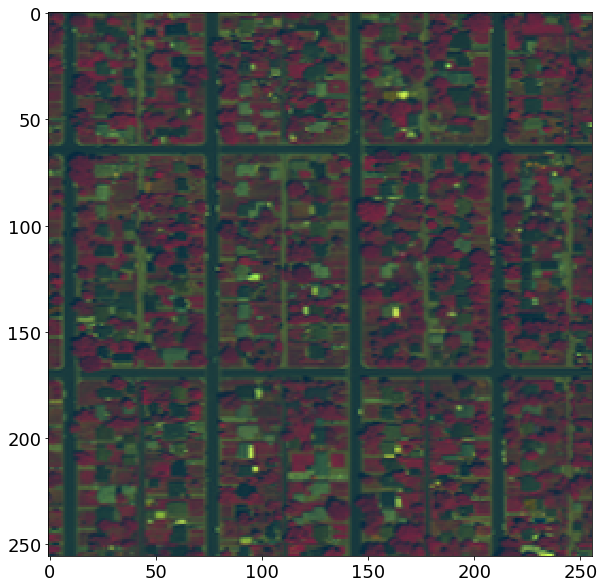

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(bytescale(pca_arr_im))
plt.show()

In [19]:
pca_arr.max()

1.5343553

Look at Kmeans of two scenes

In [20]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

2.4012163847551684
2.49132771865683
[1 2 3 4 5]


/home/ubuntu/anaconda3/envs/spatial_torch2/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


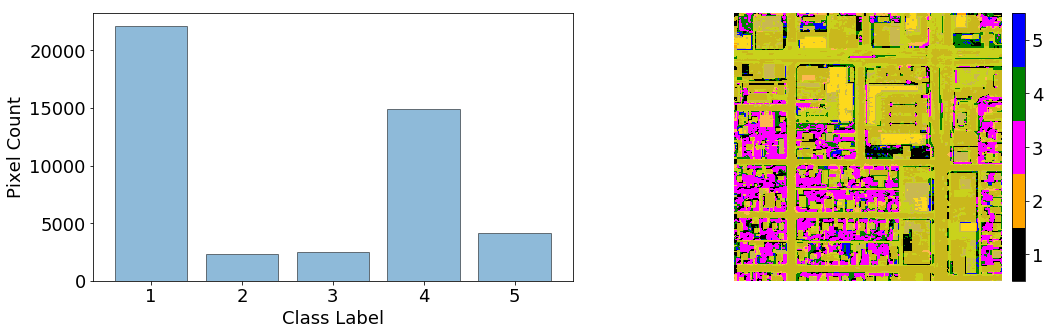

upload: figs/kmeans_test_example_42_hist.png to s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/kmeans_test_example_42_hist.png
1.123555843244265
3.064355916197405
[1 2 3 4 5]


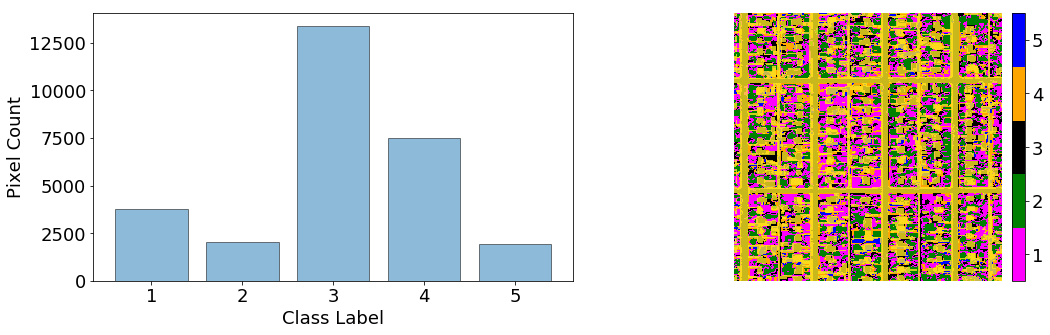

upload: figs/kmeans_test_example_107_hist.png to s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/kmeans_test_example_107_hist.png


In [39]:
for randind in [42, 107]:
    
    with rio.open(dg_files[randind]) as src:
        src_arr = src.read()
        src_arr = np.rollaxis(src_arr, 0,3)

    src_arr_reshape = src_arr.reshape((src_arr.shape[0]*src_arr.shape[1], src_arr.shape[2]))
    kmeans = KMeans(n_clusters=5, random_state=0)
    kmeans_arr = kmeans.fit_predict(src_arr_reshape)
    kmeans_arr_im = kmeans_arr.reshape((256,256))

    # read the ground truth array to summarize within
    #gt
    with rio.open(gt_files[randind]) as src:
        gt_arr = src.read(1).astype('float32')
    
    gt_arr = np.roll(gt_arr, (3,3), (0,1))
    gt_arr[gt_arr==0] = np.nan

    if randind == 42:
        cmap = matplotlib.colors.ListedColormap(['black', 'orange', 'magenta', 'green', 'blue'])
    else:
        cmap = matplotlib.colors.ListedColormap(['magenta', 'green', 'black', 'orange', 'blue'])
    
    
    
    bounds = np.arange(6)
    norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N, clip=False)
    
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    # plot the histogram
    num0 = kmeans_arr_im[(gt_arr==1) & (kmeans_arr_im == 0)].size
    num1 = kmeans_arr_im[(gt_arr==1) & (kmeans_arr_im == 1)].size
    num2 = kmeans_arr_im[(gt_arr==1) & (kmeans_arr_im == 2)].size
    num3 = kmeans_arr_im[(gt_arr==1) & (kmeans_arr_im == 3)].size
    num4 = kmeans_arr_im[(gt_arr==1) & (kmeans_arr_im == 4)].size
    ax[0].bar([1,2,3,4,5], [num0, num1, num2, num3, num4], alpha=0.5, edgecolor='k')
    ax[0].set_xlabel('Class Label')
    ax[0].set_ylabel('Pixel Count')
    
    # show images
    cf4 = ax[1].imshow(kmeans_arr_im, cmap=cmap, norm=norm)
        
    ticks = bounds + 0.5
    cb4 = fig.colorbar(cf4, ax=ax[1], orientation='vertical', shrink=1.0, pad=0.02, fraction=0.046)
    
    cb4.set_ticks(ticks)
    cb4.set_ticklabels([1,2,3,4,5])
    
    ax[1].imshow(gt_arr, cmap='viridis_r', alpha=0.8)
    plt.axis('off')
    
    #print the unique class codes and variance within the GT mask
    kmeans_arr_im += 1
    print(kmeans_arr_im[gt_arr==1].var())
    print(kmeans_arr_im[gt_arr==1].mean())
    print(np.unique(kmeans_arr_im[gt_arr==1]))
    
    
    
    fname = './figs/kmeans_test_example_{}_hist.png'.format(randind)
    plt.tight_layout()
    plt.savefig(fname)
    plt.show()
    
    !aws s3 cp $fname s3://earthlab-jmcglinchy/smart_cities/for_paper/jstars_revisions/

In [44]:
for randind in [42, 107]:
    print(f'F1 for sample {randind}: {unet_f1[randind]}')
    print(f'AP for sample {randind}: {unet_ap[randind]}')
    print(f'AUC for sample {randind}: {unet_auc[randind]}')
    print('[{0:.3f}, {1:0.3f}, {2:0.3f}]'.format(unet_f1[randind], unet_ap[randind], unet_auc[randind]))
    print()

F1 for sample 42: 0.8455506380784601
AP for sample 42: 0.8348783436923273
AUC for sample 42: 0.8173171772862333
[0.846, 0.835, 0.817]

F1 for sample 107: 0.819897024173139
AP for sample 107: 0.8182831661092531
AUC for sample 107: 0.9176907070788057
[0.820, 0.818, 0.918]



In [48]:
print('{0:0.3f}, {1:0.3f}, {2:0.3f}'.format(min(dg_lulc_f1), np.mean(dg_lulc_f1), max(dg_lulc_f1)))
print('{0:0.3f}, {1:0.3f}, {2:0.3f}'.format(min(dg_bue_f1), np.mean(dg_bue_f1), max(dg_bue_f1)))

0.733, 0.793, 0.878
0.644, 0.719, 0.846


In [49]:
print('{0:0.3f}, {1:0.3f}, {2:0.3f}'.format(min(dg_lulc_ap), np.mean(dg_lulc_ap), max(dg_lulc_ap)))
print('{0:0.3f}, {1:0.3f}, {2:0.3f}'.format(min(dg_bue_ap), np.mean(dg_bue_ap), max(dg_bue_ap)))

0.684, 0.767, 0.864
0.481, 0.574, 0.744


In [50]:
print('{0:0.3f}, {1:0.3f}, {2:0.3f}'.format(min(dg_lulc_auc), np.mean(dg_lulc_auc), max(dg_lulc_auc)))
print('{0:0.3f}, {1:0.3f}, {2:0.3f}'.format(min(dg_bue_auc), np.mean(dg_bue_auc), max(dg_bue_auc)))

0.733, 0.765, 0.820
0.530, 0.560, 0.630
